## Peptide MIC

Procedure used to train the ML models, on the data `BHII_MIC.csv`  
In version 4.2 the target values are not log2 tranformed. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

%matplotlib inline

In [3]:
data = pd.read_csv("SecVec/embed_SeqVecEmbedder_per_protein_mixed.csv", index_col=0)

data

,Peptide,Sequence,MH MIC,Strain,%Hemolysis,Source,0,1,2,3,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,BECTENECIN,RLCRIVVIRVCR,32,25922,10.120192,BH,0.096665,0.077189,-0.013444,-0.047576,...,0.079790,-0.054012,0.086812,-0.167674,0.086852,-0.069389,-0.007434,-0.129612,-0.097731,0.067300
1,BHII-1,RRRCVYRRRRRRCFCRRR,64,25922,11.057399,BH,0.130627,0.153367,0.339039,0.049621,...,0.173997,0.173937,0.060724,0.036650,0.105169,-0.121799,0.039480,-0.329793,-0.209788,-0.057066
2,BHII-10,RGRCVYGRRRRRCF,>128,25922,3.056068,BH,0.156182,-0.036645,0.230431,0.003210,...,0.188236,0.040355,0.044474,-0.133768,0.075769,-0.104359,-0.065021,-0.162763,-0.194141,-0.053120
3,BHII-11,RGRCVCGRRRCLCYYG,1,25922,51.393773,BH,0.033002,0.118404,0.192764,-0.044806,...,0.150378,0.014704,0.041388,-0.244392,0.064916,0.059235,-0.040275,-0.007804,-0.153965,0.052717
4,BHII-12,RRRCVYGRRIRLCFYGGR,2,25922,12.607445,BH,0.064118,-0.038148,0.178563,-0.019993,...,0.054830,-0.016019,0.077383,-0.181480,0.108918,-0.031165,-0.090618,-0.002658,-0.021577,-0.021969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,SySA-87,CRVRINIDNRSGRVKLEVQC,>256,W3110,4.627258,SynCH,-0.039062,-0.092385,0.142755,-0.018676,...,0.227547,-0.120108,0.221984,-0.126561,0.117773,-0.013400,0.096525,0.002474,-0.034077,0.076153
170,SySA-88,CVRVRLNNRRRGLKITLQVC,32,W3110,3.432000,SynCH,0.068020,-0.166341,0.091829,-0.070059,...,0.158621,-0.098926,0.206914,-0.120762,0.157076,-0.008889,0.014940,0.007949,0.056480,0.047324
171,SySA-9,CVRVRLNNRRRGLKISLQVC,128,W3110,1.129786,SynCH,0.078652,-0.167174,0.101334,-0.067264,...,0.144010,-0.099302,0.169026,-0.101143,0.117465,-0.020201,-0.010552,0.033240,0.063992,0.047163
172,Thanatin,GSKKPVPIIYCNRRTGKCQRM,2,25922,0.128932,BH,-0.159974,-0.075834,0.097955,0.021813,...,0.016704,0.027236,0.108677,-0.005380,-0.025770,-0.056546,0.029407,-0.130764,-0.084530,0.076528


In [4]:
# define target
data["MH MIC"].replace(">", "",  regex=True, inplace=True)
data["MH MIC"] = data["MH MIC"].astype(float)

target = data["MH MIC"]
target.describe()

count    174.000000
mean     101.216954
std      105.707864
min        0.250000
25%       16.000000
50%       48.000000
75%      256.000000
max      256.000000
Name: MH MIC, dtype: float64

(array([ 5.,  3.,  3.,  9., 11., 11., 23., 22., 20., 67.]),
 array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 <BarContainer object of 10 artists>)

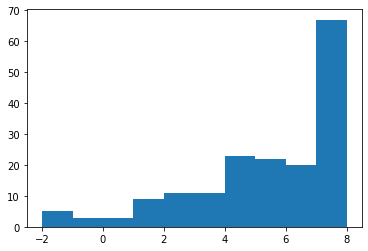

In [5]:
## target visualization and transformation
target =np.log2(target)
plt.hist(target)

In [6]:
# Fintering features by correlated columns
features = data.iloc[:, 6:]

#features = data.iloc[:, imp_feat] # important features

features

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.096665,0.077189,-0.013444,-0.047576,-0.036822,-0.065109,0.135047,0.125549,-0.109137,-0.255566,...,0.079790,-0.054012,0.086812,-0.167674,0.086852,-0.069389,-0.007434,-0.129612,-0.097731,0.067300
1,0.130627,0.153367,0.339039,0.049621,-0.017141,-0.038098,0.239135,0.398320,-0.008312,-0.240803,...,0.173997,0.173937,0.060724,0.036650,0.105169,-0.121799,0.039480,-0.329793,-0.209788,-0.057066
2,0.156182,-0.036645,0.230431,0.003210,-0.018346,-0.049342,0.094246,0.276757,-0.037667,-0.109671,...,0.188236,0.040355,0.044474,-0.133768,0.075769,-0.104359,-0.065021,-0.162763,-0.194141,-0.053120
3,0.033002,0.118404,0.192764,-0.044806,0.034304,-0.138005,0.049549,0.287287,-0.016408,0.015759,...,0.150378,0.014704,0.041388,-0.244392,0.064916,0.059235,-0.040275,-0.007804,-0.153965,0.052717
4,0.064118,-0.038148,0.178563,-0.019993,0.022520,0.023089,0.087635,0.214492,-0.034802,-0.104675,...,0.054830,-0.016019,0.077383,-0.181480,0.108918,-0.031165,-0.090618,-0.002658,-0.021577,-0.021969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,-0.039062,-0.092385,0.142755,-0.018676,-0.021426,-0.062450,-0.013280,0.186235,-0.077120,-0.023070,...,0.227547,-0.120108,0.221984,-0.126561,0.117773,-0.013400,0.096525,0.002474,-0.034077,0.076153
170,0.068020,-0.166341,0.091829,-0.070059,-0.060783,-0.017026,-0.052206,0.215034,0.022639,-0.091063,...,0.158621,-0.098926,0.206914,-0.120762,0.157076,-0.008889,0.014940,0.007949,0.056480,0.047324
171,0.078652,-0.167174,0.101334,-0.067264,-0.056911,-0.019609,-0.031774,0.206281,0.020981,-0.092084,...,0.144010,-0.099302,0.169026,-0.101143,0.117465,-0.020201,-0.010552,0.033240,0.063992,0.047163
172,-0.159974,-0.075834,0.097955,0.021813,0.079906,0.087670,-0.006210,0.079643,-0.001843,-0.114675,...,0.016704,0.027236,0.108677,-0.005380,-0.025770,-0.056546,0.029407,-0.130764,-0.084530,0.076528


In [7]:
## Data scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

features = pd.DataFrame(scaler.fit_transform(features))

In [8]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [9]:
# check the data
print(X_test.shape)

(35, 1024)


In [10]:
# check the data
print(y_test.shape)

(35,)


# Define the Model 

## Linear regression Lasso

### Finding best parans

In [11]:
%%time

# defining the model
model1 = Lasso()

# Define grid
grid = {
    'alpha': np.arange(0, 1, 0.01),
    'max_iter': [1000, 2000, 4000]
    }

cv=10

# Define search
search1 = GridSearchCV(model1, grid, scoring='r2', cv=cv, n_jobs=-1, verbose=3)

# Perform the search
results1 = search1.fit(X_train, y_train)

# Summarize
print('Mean R^2 Score of n cross validation: %.3f' % results1.best_score_)
print('Params: %s' % results1.best_params_)
print()

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
Mean R^2 Score of n cross validation: 0.662
Params: {'alpha': 0.01, 'max_iter': 1000}

CPU times: total: 2.77 s
Wall time: 21.4 s


## Features Selection

In [12]:
# Getting important features from Lasso model
coefficients = search1.best_estimator_.coef_
importance = np.abs(coefficients) > 0
print("Lenght: ", len(importance))
print("Num of importante features: ", sum(importance == True))

Lenght:  1024
Num of importante features:  59


In [13]:
coefficients[importance]

array([-0.05941566,  0.89987094, -0.31711812,  0.8995714 ,  1.29552113,
       -0.80533238,  0.07135304, -0.12920256, -0.7906234 , -0.73737994,
        1.10048415, -0.7608003 ,  0.11319232,  0.59949256, -0.07334954,
        0.44393228,  1.11021068,  0.0375658 ,  0.12081805, -0.24315204,
       -0.24503037,  1.57834614,  0.47486139, -1.36128806,  0.34276637,
       -0.02123709,  0.61191815,  0.18023869,  0.65014208, -0.64811102,
        0.47744551,  0.31955642,  0.22998604, -0.28861399,  0.54222309,
        0.79924016,  1.67594998,  0.46495317, -1.36035718,  0.19910127,
        0.71851184,  1.10410233, -1.21941843,  1.20206557,  0.50585935,
        0.57872422, -1.20746858,  0.09728927,  1.35844595,  0.43340421,
       -0.02478371,  2.1922202 ,  1.69681079,  1.56065185,  1.13352171,
       -0.00864774, -0.38971595,  1.00339314,  0.45845547])

In [14]:
X_train1 = X_train.loc[:,importance]
X_train1.columns

Int64Index([   8,    9,   23,   76,  115,  116,  120,  175,  203,  206,  230,
             234,  266,  279,  283,  292,  372,  380,  392,  395,  403,  448,
             450,  470,  491,  497,  504,  529,  547,  549,  562,  588,  595,
             606,  627,  629,  631,  632,  674,  683,  728,  789,  796,  798,
             855,  857,  863,  877,  888,  903,  907,  921,  937,  946,  972,
             987,  989,  993, 1006],
           dtype='int64')

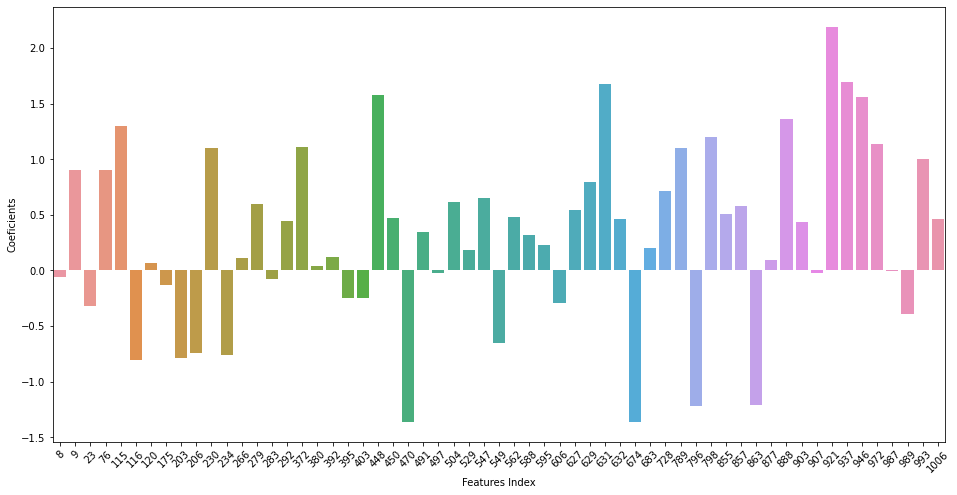

In [15]:
plt.figure(figsize=(16,8))
sns.barplot(x=X_train1.columns, y=coefficients[importance])
plt.ylabel("Coeficients")
plt.xticks(rotation=45)
plt.xlabel("Features Index")
plt.show()

### Getting important features from the Recursive Feature Elimination (or RFE)

In [16]:
from sklearn.feature_selection import RFE

# feature extraction

rfe = RFE(model1, n_features_to_select=0.1)
fit = rfe.fit(X_train, y_train)

X_train2 = X_train.loc[:, fit.support_]

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 102
Selected Features: [False False False ...  True  True  True]
Feature Ranking: [923 922 921 ...   1   1   1]


### Getting important features from the Univariate Statistical Test - f_regression

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# define feature selection
fs = SelectKBest(score_func=f_regression, k=100)

# apply feature selection
X_train3 = fs.fit_transform(X_train, y_train)
print(X_train2.shape)

(139, 102)


### Fine tunning

In [18]:
# fine tunning with the best param and features
model1= Lasso(max_iter= search1.best_params_["max_iter"], 
                                alpha= search1.best_params_["alpha"])

model1.fit(X_train1, y_train)

Lasso(alpha=0.01)

## Linear Regression OLD

In [19]:
# defining the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# fitting the model
model.fit(X_train1, y_train)

# Cross validation with R^2
cv_r2 = cross_val_score(model, X_train1, y_train, cv=10, scoring='r2')

#Summary
print(f'Cross validation R^2 score is: {cv_r2}')
print()
print(f'Mean Cross validation R^2 score is: {np.mean(cv_r2)}')
print()
print("Number of features used by the model: ", model.n_features_in_)

Cross validation R^2 score is: [0.88901341 0.90693228 0.84745578 0.89973223 0.83873058 0.90204913
 0.60530898 0.67555832 0.79435623 0.9249601 ]

Mean Cross validation R^2 score is: 0.8284097026706851

Number of features used by the model:  59


## Randon Forest Regression

In [20]:
%%time

# defining the model
model2 = RandomForestRegressor()

# Define grid
grid = {
    'n_estimators' : [10, 100, 200, 500, 1000],
    'max_depth' : [None, 5, 10, 20, 30],
    'min_samples_leaf': [1,2,4]    
    }

cv = 10

# Define search
search2 = GridSearchCV(model2, grid, scoring='r2', cv=cv, n_jobs=-1, verbose=3)

# Perform the search
results2 = search2.fit(X_train1, y_train)

# Summarize
print(f'Mean R^2 Score of {cv} cross validation: %.3f' % results2.best_score_)
print('Params: %s' % results2.best_params_)
print()

Fitting 10 folds for each of 75 candidates, totalling 750 fits
Mean R^2 Score of 10 cross validation: 0.706
Params: {'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 100}

CPU times: total: 2.48 s
Wall time: 2min 27s


**Best scores after feature selection**  
Features selected with Lasso in Xtrain1 scored: 0.710  
Features selected with RFE in Xtrain2 scored: 0.689   
Features selected with f_regression/selectkBest in Xtrain3 scored: 0.585     

### Fine tunning

In [21]:
# fine tunning with the best param and features
model2= RandomForestRegressor(max_depth= search2.best_params_["max_depth"], 
                                min_samples_leaf= search2.best_params_["min_samples_leaf"],
                                n_estimators= search2.best_params_["n_estimators"])


model2.fit(X_train1, y_train)

# Cross validation with R^2
cv_r2 = cross_val_score(model2, X_train1, y_train, cv=10, scoring='r2')

#Summary
print(f'Cross validation R^2 score is: {cv_r2}')
print()
print(f'Mean Cross validation R^2 score is: {np.mean(cv_r2)}')

Cross validation R^2 score is: [0.66556899 0.87431849 0.55587868 0.60200884 0.85399345 0.79543836
 0.60001231 0.56777309 0.65167918 0.81814772]

Mean Cross validation R^2 score is: 0.698481910420876


## Features extraction

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35,
            36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
            54, 55, 56, 57, 58],
           dtype='int64') 56


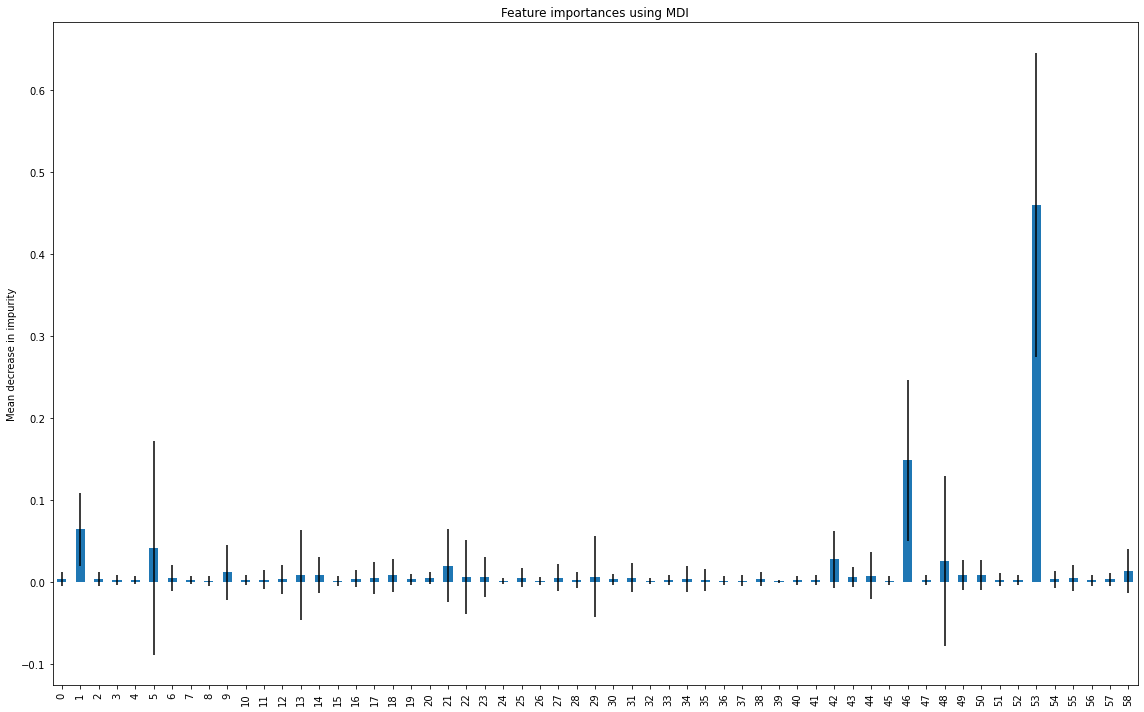

In [22]:
importances = model2.feature_importances_
std = np.std([tree.feature_importances_ for tree in model2.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots(figsize=(16,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


imp_feat =  forest_importances[forest_importances > 0.001].index
print(imp_feat, len(imp_feat))

## Cross validation scorring

In [23]:
# Cross validation with R^2
cv_r2 = cross_val_score(model, X_train1, y_train, cv=10, scoring='r2')

#summary
print(f'Cross validation of test set for R^2 score is: {cv_r2}')
print()
print(f'Mean Cross validation of test set for R^2 score is: {np.mean(cv_r2)}')

Cross validation of test set for R^2 score is: [0.88901341 0.90693228 0.84745578 0.89973223 0.83873058 0.90204913
 0.60530898 0.67555832 0.79435623 0.9249601 ]

Mean Cross validation of test set for R^2 score is: 0.8284097026706851


In [24]:
# Cross validation with Mean Score Error
cv_mae = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

#summary
print(f'Cross validation of test set for MAE score is: {cv_mae}')
print()
print(f'Mean Cross validation of test set for MAE score is: {np.mean(cv_mae)}')

Cross validation of test set for MAE score is: [-1.23431409 -1.51531509 -1.41104937 -1.38832991 -1.02393055 -1.3033277
 -1.47113528 -1.3250778  -1.63165818 -1.35616795]

Mean Cross validation of test set for MAE score is: -1.3660305931994325


In [25]:
# Cross validation with Mean Absolute Error
cv_mse = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

#summary
print(f'Cross validation of test set for MSE score is: {cv_mse}')
print()
print(f'Mean Cross validation of test set for MSE score is: {np.mean(cv_mse)}')

Cross validation of test set for MSE score is: [-2.33160472 -4.45599715 -3.18314858 -2.79015    -2.21746352 -2.90928247
 -3.71871894 -2.22967294 -3.80965189 -3.3085123 ]

Mean Cross validation of test set for MSE score is: -3.0954202502995


## Model Evaluation

In [26]:
# Making predictions
y_pred = model.predict(X_test.loc[:,importance])

In [27]:
df = pd.DataFrame(data= {"Actual Values": y_test, "Predicted Values": y_pred})
df["Differences"] = df['Predicted Values'] - df['Actual Values']
df

,Actual Values,Predicted Values,Differences
155,5.0,6.148442,1.148442
144,5.0,5.756601,0.756601
101,8.0,8.751944,0.751944
127,8.0,7.692422,-0.307578
140,8.0,8.268751,0.268751
138,8.0,7.485695,-0.514305
42,3.0,3.505137,0.505137
15,6.0,3.918156,-2.081844
126,8.0,7.524930,-0.475070
65,3.0,5.098610,2.098610


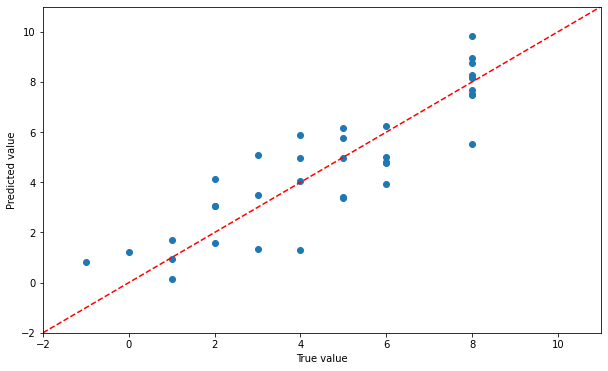

In [28]:
# Plot prediction
plt.figure(figsize=(10,6))
plt.scatter(x="Actual Values", y="Predicted Values", data=df)
plt.plot([-2,11],[-2,11],  ls="--", color="r" )
plt.xlim([-2,11])
plt.ylim([-2,11])
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.show()

In [29]:

def model_evaluate(y_test, y_pred):
    '''The best possible R2 score is 1, when the predicted values are the same as the actual values.  
    R2 score of baseline model is 0.  
    During the worse cases, R2 score can even be negative. '''
    # coeficient of determination
    r2 = r2_score(y_test, y_pred)

    # MAE - Mean absolute erro
    mae = mean_absolute_error(y_test, y_pred)

    # MSE - mean square erro
    mse = mean_squared_error(y_test, y_pred)

    print(f'R square value for the data tested is: {r2}')
    print(f'Mean absolute error for the data tested is: {mae}')
    print(f'Mean squared error for the data tested is: {mse}')


In [30]:
model_evaluate(y_test, y_pred)

R square value for the data tested is: 0.7556288584439771
Mean absolute error for the data tested is: 1.0812850316540918
Mean squared error for the data tested is: 1.6908488129215105


## Correlating Selected Features with Peptides Properties

In [128]:
df1 = data.iloc[:,6:].loc[:,importance]
df1

,8,9,23,76,115,116,120,175,203,206,...,903,907,921,937,946,972,987,989,993,1006
0,-0.109137,-0.255566,0.066259,0.091248,0.194244,-0.064988,-0.043033,-0.120833,-0.447463,-0.112584,...,-0.218202,-0.046672,0.075513,0.210062,-0.177380,0.081233,0.038869,-0.082999,0.085112,0.226434
1,-0.008312,-0.240803,0.138666,-0.037028,0.219951,0.012363,-0.020744,-0.189504,-0.431464,-0.093640,...,-0.058001,0.036211,0.230374,0.149165,-0.113188,0.172652,0.045701,0.059636,0.108729,0.235543
2,-0.037667,-0.109671,0.181451,0.059832,0.302875,-0.035504,0.047780,-0.255850,-0.440731,-0.099918,...,-0.042385,-0.015585,0.095132,0.178804,-0.079108,0.148515,0.174207,0.026962,0.051461,0.238505
3,-0.016408,0.015759,0.125560,-0.005456,0.240965,0.092046,-0.149912,-0.231165,-0.412416,-0.102603,...,-0.132118,0.068963,0.020825,0.116804,-0.196950,-0.023747,0.022907,-0.047992,-0.005734,0.149928
4,-0.034802,-0.104675,0.126604,0.064224,0.237294,0.041428,0.046804,-0.118204,-0.405826,-0.106989,...,-0.067862,0.022291,0.066219,0.161830,-0.184534,0.078410,-0.032421,-0.014224,0.048903,0.266713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,-0.077120,-0.023070,0.081293,0.045215,0.261143,-0.159146,0.047279,-0.078062,-0.376695,-0.186071,...,-0.130619,0.088392,0.165424,0.065189,-0.008412,0.000786,0.069528,-0.023903,0.146877,0.199093
170,0.022639,-0.091063,0.066180,-0.012557,0.265768,-0.102341,-0.113830,-0.175616,-0.389680,-0.185327,...,-0.118015,0.139892,0.105137,0.004738,-0.082724,0.108238,0.111417,0.034433,0.064252,0.144983
171,0.020981,-0.092084,0.062365,-0.016450,0.270435,-0.107046,-0.120918,-0.189887,-0.393338,-0.185219,...,-0.078596,0.120585,0.122378,0.019516,-0.091210,0.102730,0.100652,0.044839,0.039098,0.164877
172,-0.001843,-0.114675,0.152484,0.042723,0.215218,-0.039305,0.182010,-0.044513,-0.378937,-0.097444,...,-0.252520,0.096957,-0.051555,-0.053121,-0.176793,-0.063531,0.101980,-0.124808,0.101359,0.137145


In [129]:
df2 = pd.read_excel("Theoretical_Physicochemical_Properties_of_Peptide_Sequences.xlsx", index_col=0)
df2 

,Peptide,Sequence,MH.MIC,Hemolysis,Tiny,Small,Aliphatic,Aromatic,NonPolar,Polar,...,zScale_5,VHSE-scale_1,VHSE-scale_2,VHSE-scale_3,VHSE-scale_4,VHSE-scale_5,VHSE-scale_6,VHSE-scale_7,VHSE-scale_8,Pep_length
6,BHII-12.2,RRRCVYGRRNRLCFYGGR,8.0,0.712548,27.778,38.889,11.111,16.667,55.556,44.444,...,-0.486667,-0.370000,0.287778,0.166111,0.810556,0.581111,0.445000,0.512778,-0.071111,18
18,BHII-18,RCRCVCRRRKCRCFWR,8.0,23.560192,31.250,37.500,6.250,12.500,50.000,50.000,...,-1.022500,-0.423750,0.265625,0.603750,0.457500,0.856875,0.981875,0.006250,0.244375,16
32,BHII-25.2,RGKCVCNRRRCRCYRR,8.0,0.393929,31.250,43.750,6.250,6.250,43.750,56.250,...,-0.733750,-0.660000,0.207500,0.346250,0.665000,0.760000,0.892500,0.364375,0.155625,16
37,BHII-26,RGRCVCIRRRCRCYYRGR,8.0,26.693900,33.333,38.889,11.111,11.111,55.556,44.444,...,-0.856667,-0.455000,0.222222,0.293889,0.646111,0.717778,0.649444,0.314444,0.111111,18
42,BHII-30,RCKCVCIRRKCRCFCRGK,8.0,37.503870,38.889,44.444,11.111,5.556,55.556,44.444,...,-0.921111,-0.357222,-0.147222,0.222222,0.327778,0.717222,0.702778,0.111667,0.094444,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,BHII-12.8,RRRCVCGRRNCLCGQGRR,16.0,0.139034,38.889,50.000,11.111,0.000,50.000,50.000,...,-0.546667,-0.555556,-0.102778,-0.058333,0.723889,0.513333,0.558333,0.503333,-0.046111,18
35,BHII-25.5,RGKCVCNRRRCLCRRR,16.0,0.376550,31.250,43.750,12.500,0.000,43.750,56.250,...,-0.589375,-0.613125,0.111875,0.295625,0.569375,0.740625,0.791250,0.429375,0.149375,16
58,BHII-43.3,RGRCVCNRRKCRCYRGRT,16.0,0.191171,38.889,50.000,5.556,5.556,44.444,55.556,...,-0.695556,-0.616667,0.071111,0.131111,0.658889,0.642778,0.727222,0.391667,0.085556,18
60,BHII-43.5,RGRCTCNRRKCRCQRGRT,16.0,0.167999,44.444,50.000,0.000,0.000,33.333,66.667,...,-0.598333,-0.765000,0.011667,0.055000,0.674444,0.602778,0.813889,0.403333,0.115000,18


In [151]:
df3 = pd.read_csv("../data/aa_composition_mixed.csv", low_memory=False, index_col=0)
# define target
df3["MH MIC"].replace(">", "",  regex=True, inplace=True)
df3["MH MIC"] = df3["MH MIC"].astype(float)
df3 

,Peptide,Sequence,MH MIC,Strain,%Hemolysis,Source,AAC_A,AAC_C,AAC_D,AAC_E,...,PRI_HX.1,PRI_SC.1,PRI_SS_HE.1,PRI_SS_ST.1,PRI_SS_CO.1,PRI_SA_BU.1,PRI_SA_EX.1,PRI_SA_IN.1,PRI_TN.1,PRI_SM.1
0,BECTENECIN,RLCRIVVIRVCR,32.0,25922,10.120192,BH,0.0,16.67,0.0,0.0,...,0.0,0.50,0.44,0.43,0.00,0.38,0.00,0.00,0.50,0.36
1,BHII-1,RRRCVYRRRRRRCFCRRR,64.0,25922,11.057399,BH,0.0,16.67,0.0,0.0,...,0.0,0.33,0.45,0.50,0.00,0.52,0.00,1.00,0.33,0.38
2,BHII-10,RGRCVYGRRRRRCF,128.0,25922,3.056068,BH,0.0,27.78,0.0,0.0,...,0.0,0.20,0.31,0.28,0.38,0.51,1.00,1.00,0.19,0.18
3,BHII-11,RGRCVCGRRRCLCYYG,1.0,25922,51.393773,BH,0.0,22.22,0.0,0.0,...,0.0,0.25,0.43,0.51,0.00,0.51,0.00,0.00,0.25,0.50
4,BHII-12,RRRCVYGRRIRLCFYGGR,2.0,25922,12.607445,BH,0.0,12.50,0.0,0.0,...,0.0,0.50,0.28,0.41,2.00,0.24,0.00,0.56,0.44,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,SySA-87,CRVRINIDNRSGRVKLEVQC,256.0,W3110,4.627258,SynCH,0.0,10.00,0.0,5.0,...,0.5,2.00,0.28,0.30,1.00,0.17,0.38,0.50,0.72,0.39
170,SySA-88,CVRVRLNNRRRGLKITLQVC,32.0,W3110,3.432000,SynCH,0.0,10.00,5.0,5.0,...,1.0,2.00,0.22,0.19,0.36,0.14,0.22,1.00,0.67,0.17
171,SySA-9,CVRVRLNNRRRGLKISLQVC,128.0,W3110,1.129786,SynCH,0.0,10.00,0.0,0.0,...,1.0,2.00,0.22,0.36,0.56,0.20,0.38,1.00,0.75,0.23
172,Thanatin,GSKKPVPIIYCNRRTGKCQRM,2.0,25922,0.128932,BH,0.0,9.52,0.0,0.0,...,0.5,0.75,0.37,0.39,0.22,0.18,0.27,0.24,0.28,0.22


## Finding correlations

**An important rule to remember is that Correlation doesn’t imply causation**

### Correlation with peptide properties

In [133]:
# correlatin each column in data1 (x) with columns in data2
corr_data1 = df1.apply(lambda x: df2.iloc[:,4:].corrwith(x, method='pearson'), axis=0)
corr_data1

,8,9,23,76,115,116,120,175,203,206,...,903,907,921,937,946,972,987,989,993,1006
Tiny,-0.473947,0.211813,0.330564,-0.007488,-0.607519,0.621536,-0.151339,-0.193585,0.321941,0.213275,...,-0.317891,-0.079533,-0.413509,0.523885,-0.278456,-0.152041,-0.168873,-0.422336,-0.343351,-0.445301
Small,0.243297,0.458169,-0.512809,0.044365,0.089714,-0.519959,0.289801,0.467393,0.289566,-0.564260,...,0.142506,0.145764,-0.391933,-0.131084,0.512041,-0.111419,0.104939,-0.131168,-0.202847,-0.435985
Aliphatic,0.555131,0.159252,-0.801853,-0.001697,0.617323,-0.871495,0.357379,0.525918,-0.051804,-0.548360,...,0.480447,0.251136,-0.027497,-0.494729,0.599350,0.143648,0.160242,0.275562,0.075358,0.025482
Aromatic,-0.270002,-0.292624,0.598973,0.216977,-0.224321,0.716410,-0.026934,-0.271991,0.099718,0.598699,...,-0.314731,-0.363233,-0.117991,0.314401,-0.595652,-0.034505,-0.242662,-0.177189,-0.028881,0.129864
NonPolar,-0.037513,0.090243,-0.105153,0.125509,0.029415,0.250845,0.222010,0.184176,0.289126,0.164878,...,0.007924,-0.133267,-0.659280,0.244310,-0.220575,0.053543,-0.168693,-0.321123,-0.284103,-0.170072
Polar,0.037513,-0.090243,0.105153,-0.125509,-0.029415,-0.250845,-0.222010,-0.184176,-0.289126,-0.164878,...,-0.007924,0.133267,0.659280,-0.244310,0.220575,-0.053543,0.168693,0.321123,0.284103,0.170072
Charged,-0.357677,-0.441424,0.693828,-0.119523,-0.467699,0.717760,-0.438381,-0.520807,-0.229982,0.566045,...,-0.316477,-0.240754,0.425039,0.441511,-0.482995,0.081284,-0.037596,0.025269,-0.031895,0.192548
Basic,-0.328842,-0.520789,0.766900,-0.170760,-0.473996,0.778525,-0.521890,-0.603298,-0.265436,0.645953,...,-0.384225,-0.320809,0.283663,0.468563,-0.620568,0.107108,0.016089,-0.011557,-0.138067,0.206170
Acidic,0.058695,0.422348,-0.506553,0.204912,0.210690,-0.478889,0.433718,0.464372,0.202100,-0.475035,...,0.335822,0.342274,0.256297,-0.263145,0.616558,-0.111897,-0.148022,0.101749,0.336250,-0.120314
MW,0.299078,-0.094072,-0.119219,-0.063437,0.137767,-0.339379,-0.073312,0.081748,-0.033982,-0.247164,...,0.115629,0.334953,0.355840,-0.420725,0.121951,-0.069836,-0.048824,0.413667,0.259485,0.228469


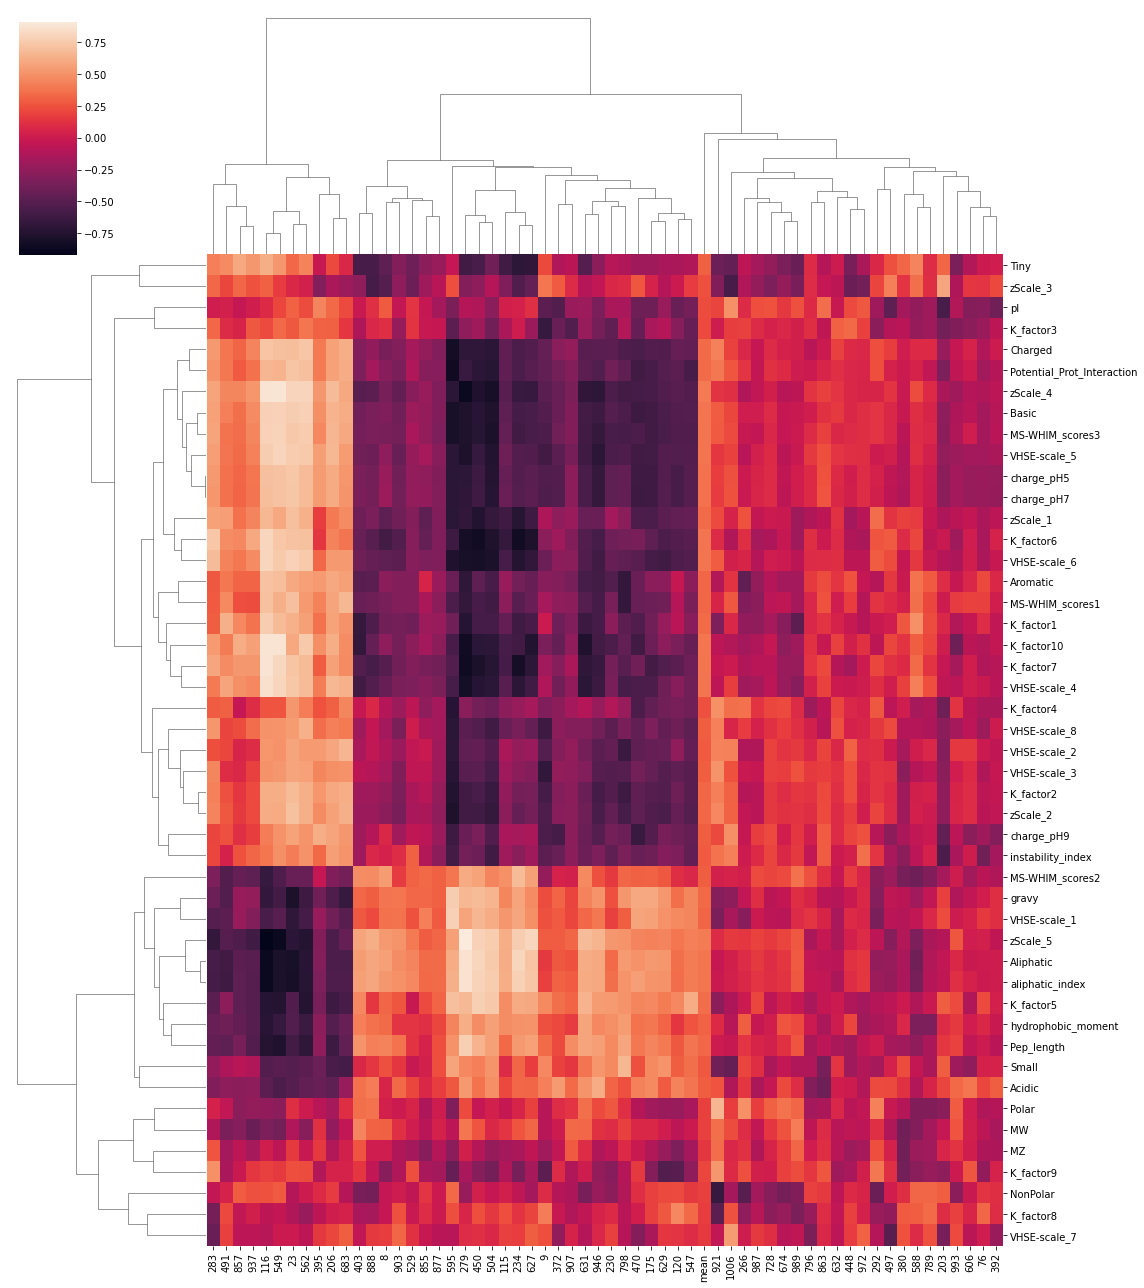

In [176]:
sns.clustermap(corr_data1, figsize=(16, 18))

<AxesSubplot:xlabel='zScale_4', ylabel='MH.MIC'>

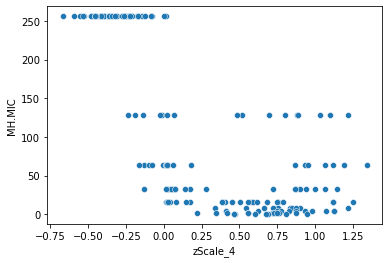

In [179]:
sns.scatterplot(y=df2['MH.MIC'], x=df2['zScale_4'])

<AxesSubplot:xlabel='K_factor10', ylabel='MH.MIC'>

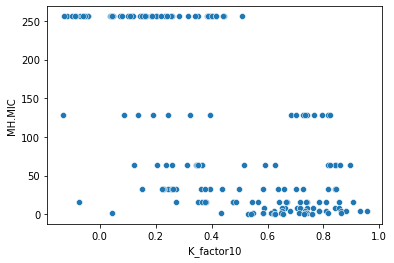

In [180]:
sns.scatterplot(y=df2['MH.MIC'], x=df2['K_factor10'])

<AxesSubplot:xlabel='VHSE-scale_4', ylabel='MH.MIC'>

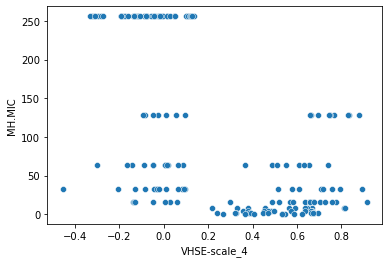

In [184]:
sns.scatterplot(y=df2['MH.MIC'], x=df2['VHSE-scale_4'])

<AxesSubplot:xlabel='zScale_5', ylabel='MH.MIC'>

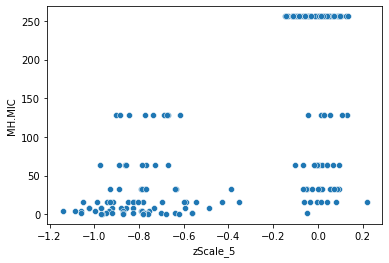

In [181]:
sns.scatterplot(y=df2['MH.MIC'], x=df2['zScale_5'])

<AxesSubplot:xlabel='Aliphatic', ylabel='MH.MIC'>

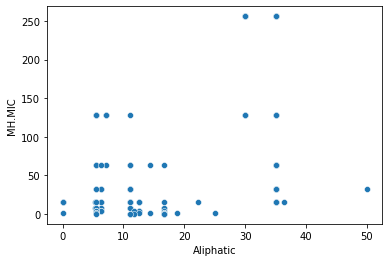

In [136]:
sns.scatterplot(y=df2['MH.MIC'], x=df2['Aliphatic'])

<AxesSubplot:xlabel='aliphatic_index', ylabel='MH.MIC'>

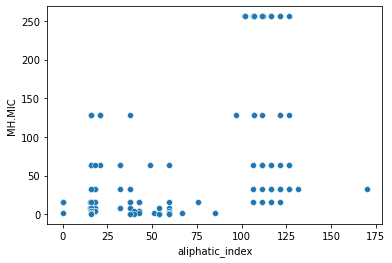

In [183]:
sns.scatterplot(y=df2['MH.MIC'], x=df2['aliphatic_index'])

<AxesSubplot:xlabel='Basic', ylabel='MH.MIC'>

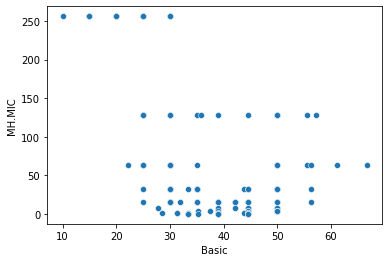

In [137]:
sns.scatterplot(y=df2['MH.MIC'], x=df2['Basic'])

<AxesSubplot:xlabel='MS-WHIM_scores3', ylabel='MH.MIC'>

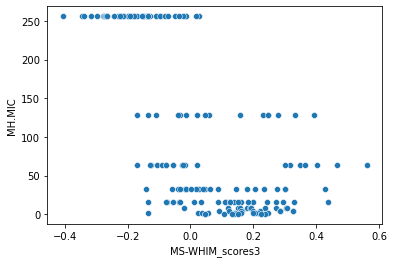

In [138]:
sns.scatterplot(y=df2['MH.MIC'], x=df2['MS-WHIM_scores3'])

<AxesSubplot:xlabel='charge_pH7', ylabel='MH.MIC'>

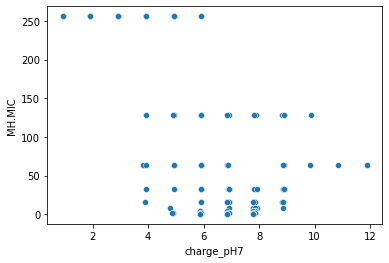

In [139]:
sns.scatterplot(y=df2['MH.MIC'], x=df2['charge_pH7'])

<AxesSubplot:xlabel='Potential_Prot_Interaction', ylabel='MH.MIC'>

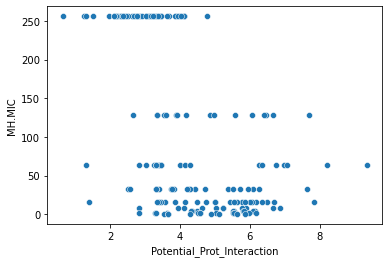

In [185]:
sns.scatterplot(y=df2['MH.MIC'], x=df2['Potential_Prot_Interaction'])

### Correlation with amino acid composition

**Composition Based Features**

Feature claass | Description | Function
---|---|---
AAC | Amino acid composition | aac_wp
DPC | Dipeptide composition | dpc_wp
TPC | Tripeptide composition | tpc_wp
ABC | Atom and bond composition | atc_wp, btc_wp
PCP | Physico-chemical properties | pcp_wp
AAI | Amino acid index composition | aai_wp
RRI | Repetitive Residue Information | rri_wp
DDR | Distance distribution of residues |ddr_wp
PRI | Physico-chemical properties repeat composition | pri_wp
SEP | Shannon entropy | sep_wp
SER | Shannon entropy of residue level | ser_wp
SPC | Shannon entropy of physicochemical property | spc_wp
ACR | Autocorrelation | acr_wp
CTC | Conjoint Triad Calculation | ctc_wp
CTD | Composition enhanced transition distribution | ctd_wp
PAAC | Pseudo amino acid composition | paac_wp
APAAC | Amphiphilic pseudo amino acid composition | apaac_wp
QSO | Quasi sequence order | qos_wp
SOC | Sequence order coupling | soc_wp

In [143]:
# correlatin each column in data1 (x) with columns in data2
corr_data2 = df1.apply(lambda x: df3.iloc[:,6:].corrwith(x, method='pearson'), axis=0, )
corr_data2

,8,9,23,76,115,116,120,175,203,206,...,903,907,921,937,946,972,987,989,993,1006
AAC_A,0.006978,-0.047551,-0.025758,0.117090,0.028504,-0.049884,0.022807,-0.038048,0.030056,0.001499,...,0.072666,-0.062604,0.086376,0.007891,0.104948,0.027800,0.000183,0.208496,-0.123475,0.045494
AAC_C,-0.547209,-0.252735,0.652952,-0.023762,-0.585600,0.769676,-0.431322,-0.474406,0.096300,0.394242,...,-0.460107,-0.249473,-0.024484,0.507055,-0.559359,-0.078616,-0.068347,-0.210371,-0.228868,-0.170948
AAC_D,0.138056,0.123710,-0.344453,-0.008986,0.196196,-0.342531,0.086867,0.218171,-0.060634,-0.289907,...,0.147096,0.179489,0.187701,-0.270862,0.256517,-0.044658,-0.098913,0.083462,0.203086,0.050615
AAC_E,0.216814,0.160653,-0.343085,0.005253,0.272975,-0.484133,0.096459,0.201228,-0.011635,-0.304424,...,0.153014,0.180336,0.071912,-0.290244,0.335828,0.039166,0.127837,0.200196,0.146588,0.015264
AAC_F,-0.150233,-0.257051,0.326764,0.045220,-0.144455,0.430774,-0.053355,-0.176794,-0.061448,0.348229,...,-0.070116,-0.284036,-0.135759,0.306602,-0.433308,-0.016171,-0.026007,-0.197776,-0.094990,0.129814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRI_SA_BU.1,-0.225266,-0.308491,0.517620,-0.005076,-0.334503,0.661208,-0.143946,-0.308700,-0.150650,0.560202,...,-0.121925,-0.374630,-0.032436,0.461169,-0.454188,0.150634,-0.116780,-0.177616,-0.183504,0.172063
PRI_SA_EX.1,-0.217002,0.034876,0.246834,0.044503,-0.249487,0.332961,-0.181270,-0.221239,0.078148,0.121225,...,-0.175331,-0.006811,-0.087923,0.122725,-0.193200,-0.076243,0.111599,-0.162307,0.099650,-0.011931
PRI_SA_IN.1,-0.137653,0.124056,0.069573,-0.021021,-0.233939,0.029626,-0.122061,-0.136606,0.107049,0.004224,...,-0.132808,0.017386,-0.083120,-0.054334,0.036802,-0.163062,-0.007620,0.072427,-0.061051,-0.184594
PRI_TN.1,0.336180,0.165023,-0.475258,-0.034989,0.432221,-0.620033,0.175950,0.260148,-0.078371,-0.402210,...,0.326698,0.268042,0.128744,-0.388440,0.419449,0.058619,0.137789,0.197461,0.173076,0.126778


In [193]:
#corr_data2.apply(lambda x: np.absolute(x) > 0.5, axis=1 )
corr_data2['abs_mean'] = corr_data2.apply(lambda x: np.abs(x).mean(), axis=1)
corr2 = corr_data2.query('abs_mean >= 0.3')
corr2

,8,9,23,76,115,116,120,175,203,206,...,921,937,946,972,987,989,993,1006,mean,abs_mean
AAC_C,-0.547209,-0.252735,0.652952,-0.023762,-0.585600,0.769676,-0.431322,-0.474406,0.096300,0.394242,...,-0.024484,0.507055,-0.559359,-0.078616,-0.068347,-0.210371,-0.228868,-0.170948,-0.107914,0.344279
AAC_L,0.414102,0.256397,-0.600458,0.055759,0.452706,-0.669150,0.290854,0.390757,-0.057027,-0.478062,...,0.126177,-0.429426,0.500831,0.062177,-0.015234,0.187011,0.177587,0.020501,0.094812,0.306409
AAC_N,0.464308,0.282835,-0.585303,-0.029415,0.496410,-0.813277,0.219008,0.348669,-0.007621,-0.573053,...,0.092608,-0.497659,0.596569,0.052910,0.195331,0.289798,0.111984,-0.030242,0.093518,0.339043
AAC_R,-0.304337,-0.348944,0.628639,-0.078735,-0.543423,0.768921,-0.341119,-0.374835,-0.093298,0.563520,...,0.127045,0.481654,-0.511290,0.082608,-0.189759,-0.109020,-0.175768,0.064848,-0.088122,0.333255
AAC_S,0.452072,0.215848,-0.579752,-0.003326,0.394406,-0.682155,0.331544,0.445198,0.034850,-0.484963,...,0.025832,-0.443790,0.570652,0.072994,0.125311,0.194765,0.051336,-0.105868,0.094879,0.301780
ATC_H,0.301988,0.371284,-0.554147,-0.016838,0.441799,-0.738003,0.244163,0.301984,0.032286,-0.538639,...,-0.022416,-0.476332,0.514176,-0.058516,0.167456,0.145859,0.162436,-0.059168,0.079395,0.307621
ATC_N,0.387029,0.189738,-0.693637,-0.023412,0.482833,-0.759605,0.283917,0.444109,-0.050154,-0.542420,...,0.031570,-0.385537,0.641539,0.141646,0.220768,0.211265,0.100726,-0.043857,0.106663,0.338849
ATC_O,-0.326467,-0.274676,0.644734,-0.103987,-0.577056,0.754983,-0.401670,-0.440567,-0.083059,0.506263,...,0.124378,0.493370,-0.478871,0.060286,-0.132744,-0.103420,-0.199184,0.014175,-0.094767,0.327657
ATC_S,-0.545816,-0.217690,0.634045,-0.018182,-0.573540,0.738051,-0.414016,-0.475457,0.104209,0.372678,...,-0.056704,0.490629,-0.543955,-0.095947,-0.047239,-0.229166,-0.230786,-0.185601,-0.107892,0.335458
PCP_PC,-0.384182,-0.325465,0.650215,-0.038606,-0.563826,0.810450,-0.364119,-0.408262,-0.032256,0.551125,...,0.092731,0.505529,-0.521370,0.043156,-0.139469,-0.144205,-0.148280,0.030977,-0.090994,0.342236


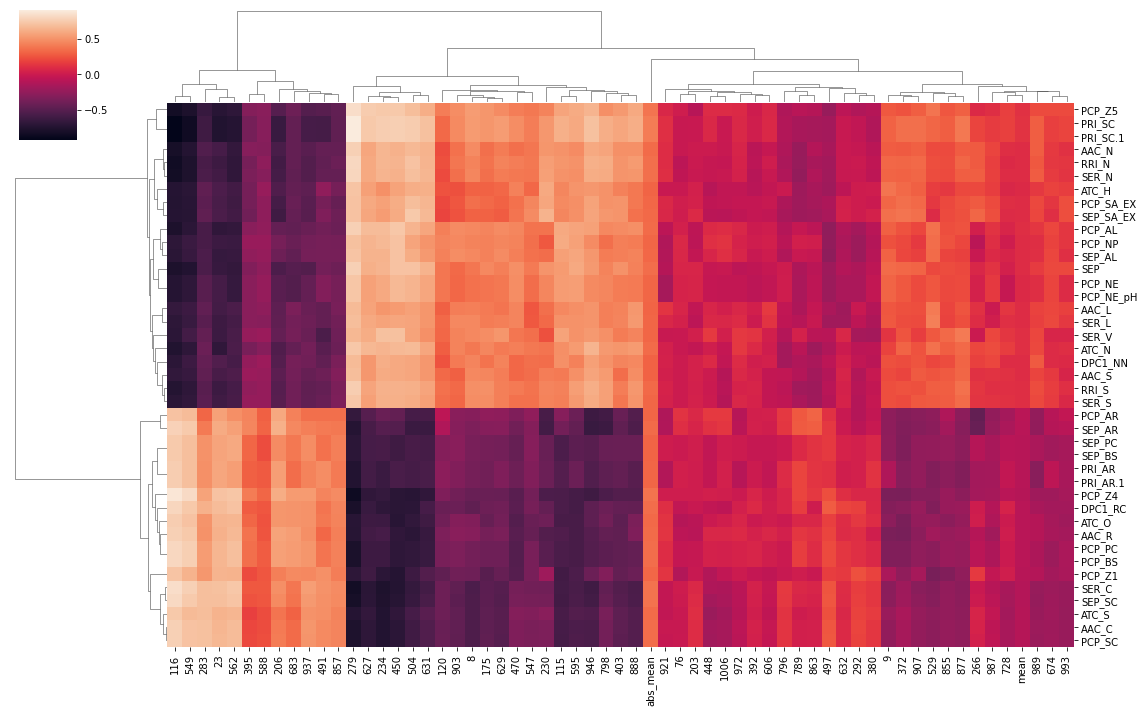

In [194]:
sns.clustermap(
    corr2,
    row_cluster=True,
    dendrogram_ratio=0.15,
    figsize=(16, 10))

<AxesSubplot:xlabel='ATC_N', ylabel='MH MIC'>

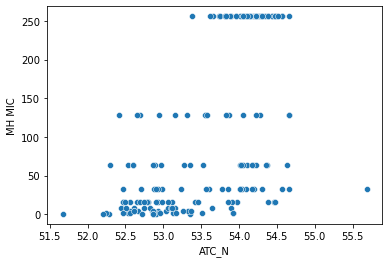

In [166]:
#Atom and bond composition
sns.scatterplot(y=df3['MH MIC'], x=df3['ATC_N'])

<AxesSubplot:xlabel='PCP_AL', ylabel='MH MIC'>

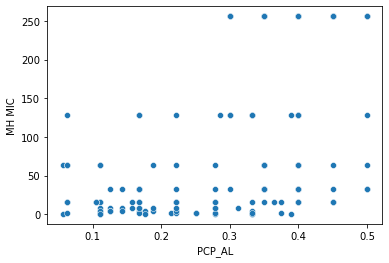

In [167]:
# Physico-chemical properties
sns.scatterplot(y=df3['MH MIC'], x=df3['PCP_AL'])

<AxesSubplot:xlabel='PCP_Z5', ylabel='MH MIC'>

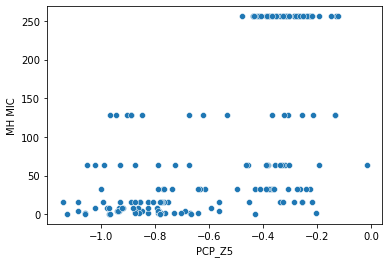

In [168]:
# Physico-chemical properties
sns.scatterplot(y=df3['MH MIC'], x=df3['PCP_Z5'])

<AxesSubplot:xlabel='PCP_BS', ylabel='MH MIC'>

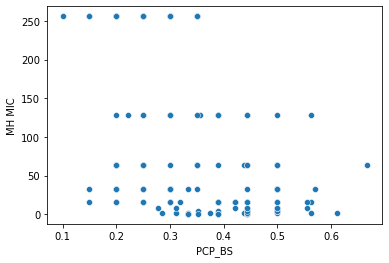

In [195]:
# Physico-chemical properties
sns.scatterplot(y=df3['MH MIC'], x=df3['PCP_BS'])

<AxesSubplot:xlabel='SEP_AR', ylabel='MH MIC'>

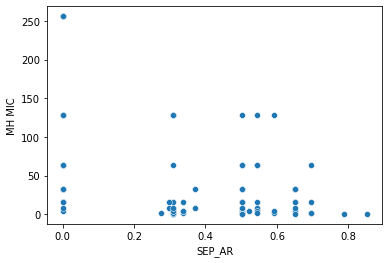

In [199]:
# Shannon entropy
sns.scatterplot(y=df3['MH MIC'], x=df3['SEP_AR'])

<AxesSubplot:xlabel='SER_V', ylabel='MH MIC'>

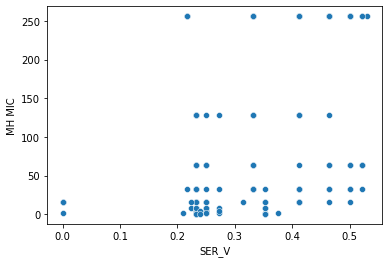

In [198]:
# Shannon entropy of residue level
sns.scatterplot(y=df3['MH MIC'], x=df3['SER_V'])

<AxesSubplot:xlabel='PRI_SC', ylabel='MH MIC'>

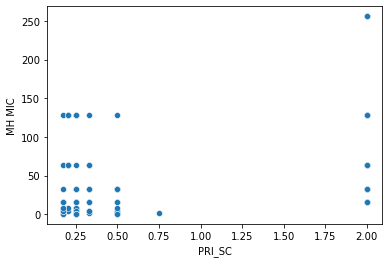

In [171]:
sns.scatterplot(y=df3['MH MIC'], x=df3['PRI_SC'])

<AxesSubplot:xlabel='PRI_SC.1', ylabel='MH MIC'>

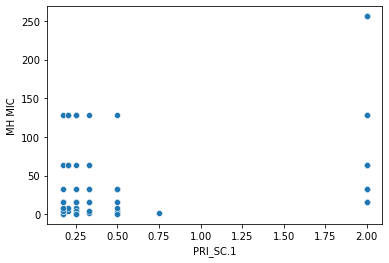

In [172]:
sns.scatterplot(y=df3['MH MIC'], x=df3['PRI_SC.1'])

<AxesSubplot:xlabel='AAC_R', ylabel='MH MIC'>

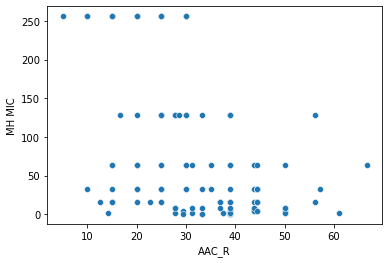

In [197]:
sns.scatterplot(y=df3['MH MIC'], x=df3['AAC_R'])

In [ ]:
sns.scatterplot(y=df3['MH MIC'], x=df3[''])

In [ ]:
sns.scatterplot(y=df3['MH MIC'], x=df3[''])

### Session information

In [ ]:
import session_info
session_info.show()